In [ ]:
import getpass
from google.colab import auth
from oauth2client.client import GoogleCredentials


!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&ac

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download qramkrishna/corn-leaf-infection-dataset

100% 13.0G/13.0G [04:41<00:00, 99.4MB/s]
100% 13.0G/13.0G [04:41<00:00, 49.6MB/s]


In [ ]:
!unzip corn-leaf-infection-dataset.zip
!rm corn-leaf-infection-dataset.zip

In [ ]:
!ls Corn\ Disease\ detection

'Healthy corn'	 Infected


In [ ]:
import torch
import pandas as pd
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
BATCH_SIZE = 64
CROP_SIZE = 224

transform = transforms.Compose([
    transforms.RandomResizedCrop(CROP_SIZE, scale=(0.7, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ImageFolder('/content/Corn Disease detection/', transform=transform)

In [ ]:
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3168
633
424


In [ ]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
classes = ['Healthy corn', 'Infected']

In [ ]:
feature, target = next(iter(trainloader))
print(feature.shape)
type(feature)

torch.Size([64, 3, 224, 224])


torch.Tensor

In [ ]:
from torchvision.models import mobilenet_v3_large

class CornLeafClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_large(pretrained=True)
        self.freeze()
        self.mobilenet.classifier = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        return self.mobilenet(x)
    
    def freeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        
    def unfreeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = True

In [ ]:
model = CornLeafClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
model

CornLeafClassifier(
  (mobilenet): MobileNetV3(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivati

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
from tqdm.auto import tqdm

def loop_function(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()

    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
epochs = 20
save_epoch = []
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range(epochs):
    cost_train, acc_train = loop_function("train", train_dataset, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost_train)
    train_acc.append(acc_train)
    with torch.no_grad():
        cost_val, acc_val = loop_function("val", val_dataset, validationloader, model, criterion, optimizer, device)
        val_cost.append(cost_val)
        val_acc.append(acc_val)
    save_epoch.append(i+1)
    scheduler.step()

    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
          f"train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f} | Learning Rate: {scheduler.get_last_lr()}")

Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/20 | train_cost: 0.2802 | val_cost: 0.1081 | train_acc: 0.8924 | val_acc: 0.9589 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/20 | train_cost: 0.1349 | val_cost: 0.0795 | train_acc: 0.9470 | val_acc: 0.9652 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/20 | train_cost: 0.1562 | val_cost: 0.1256 | train_acc: 0.9356 | val_acc: 0.9510 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/20 | train_cost: 0.1019 | val_cost: 0.0893 | train_acc: 0.9609 | val_acc: 0.9700 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/20 | train_cost: 0.0684 | val_cost: 0.1026 | train_acc: 0.9747 | val_acc: 0.9684 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/20 | train_cost: 0.0676 | val_cost: 0.0640 | train_acc: 0.9747 | val_acc: 0.9795 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/20 | train_cost: 0.0542 | val_cost: 0.1095 | train_acc: 0.9785 | val_acc: 0.9589 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/20 | train_cost: 0.0662 | val_cost: 0.0743 | train_acc: 0.9744 | val_acc: 0.9668 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/20 | train_cost: 0.0547 | val_cost: 0.0725 | train_acc: 0.9766 | val_acc: 0.9700 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/20 | train_cost: 0.0544 | val_cost: 0.2424 | train_acc: 0.9801 | val_acc: 0.9163 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/20 | train_cost: 0.0725 | val_cost: 0.0630 | train_acc: 0.9747 | val_acc: 0.9763 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/20 | train_cost: 0.0260 | val_cost: 0.0521 | train_acc: 0.9927 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/20 | train_cost: 0.0265 | val_cost: 0.0481 | train_acc: 0.9905 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/20 | train_cost: 0.0240 | val_cost: 0.0492 | train_acc: 0.9915 | val_acc: 0.9826 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/20 | train_cost: 0.0236 | val_cost: 0.0380 | train_acc: 0.9905 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/20 | train_cost: 0.0221 | val_cost: 0.0548 | train_acc: 0.9927 | val_acc: 0.9826 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/20 | train_cost: 0.0221 | val_cost: 0.0604 | train_acc: 0.9924 | val_acc: 0.9795 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/20 | train_cost: 0.0389 | val_cost: 0.0739 | train_acc: 0.9861 | val_acc: 0.9779 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/20 | train_cost: 0.0240 | val_cost: 0.0397 | train_acc: 0.9902 | val_acc: 0.9842 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/20 | train_cost: 0.0242 | val_cost: 0.0475 | train_acc: 0.9918 | val_acc: 0.9826 | Learning Rate: [1e-05]


In [ ]:
torch.save({
    "epoch": i,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": criterion,
    "scheduler": scheduler.state_dict() 
}, "model_checkpoint.pth")

torch.save(model.state_dict(), "model_save.pth")

In [ ]:
from pandas import DataFrame

#save loss
cost_graph = [save_epoch, train_cost, val_cost]
loss = DataFrame(cost_graph).transpose()
loss.columns=['epoch','train_cost','val_cost']
loss.to_csv('sch_loss_history_epoch_1-35.csv')

#save accuracy
acc_graph = [save_epoch, train_acc, val_acc]
accuracy = DataFrame(acc_graph).transpose()
accuracy.columns=['epoch','train_acc','val_acc']
accuracy.to_csv('sch_acc_history_epoch_1-35.csv')

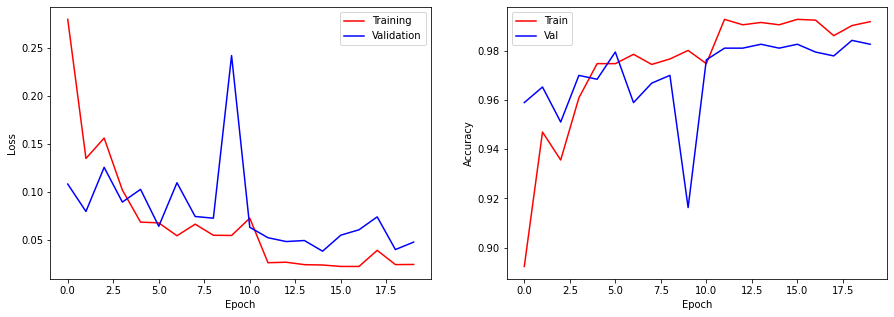

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='Training')
plt.plot(val_cost, 'b-', label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(122)
plt.plot(train_acc, 'r-', label='Train')
plt.plot(val_acc, 'b-', label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

In [ ]:
!cp model_save.pth model_checkpoint.pth sch_acc_history_epoch_1-35.csv sch_loss_history_epoch_1-35.csv /content/drive/MyDrive/corn-leaf-infection

# Resume Training

In [ ]:
!cp /content/drive/MyDrive/corn-leaf-infection/model_checkpoint.pth /content/
!cp /content/drive/MyDrive/corn-leaf-infection/sch_acc_history_epoch_1-35.csv /content/
!cp /content/drive/MyDrive/corn-leaf-infection/sch_loss_history_epoch_1-35.csv /content/

In [ ]:
# epochs = 35
new_epochs = 21
# load the model checkpoint
checkpoint = torch.load('model_checkpoint.pth')

# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')

# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
epochs = checkpoint['epoch']
print(f"Jumlah epoch {epochs}")

# load the criterion
criterion = checkpoint['loss']
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")

#load scheduler
scheduler.load_state_dict(checkpoint['scheduler'])
print('Scheduler loaded....')

# train for more epochs
epochs += new_epochs
print(f"Total number of Epochs {epochs}")
print(f"Train for {new_epochs} more epochs...")

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Jumlah epoch 19
Trained model loss function loaded...
Previously trained for 19 number of epochs...
Scheduler loaded....
Total number of Epochs 40
Train for 21 more epochs...


In [ ]:
save_epoch = []
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range(21, 41):
    cost_train, acc_train = loop_function('train', train_dataset, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost_train)
    train_acc.append(acc_train)
    with torch.no_grad():
        cost_val, acc_val = loop_function('val', val_dataset, validationloader, model, criterion, optimizer, device)
        val_cost.append(cost_val)
        val_acc.append(acc_val)
    save_epoch.append(i)
    scheduler.step()
      
    print(f"\rEpoch: {i}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
          f"train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f} | Learning rate: {scheduler.get_last_lr()}")

Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/40 | train_cost: 0.0324 | val_cost: 0.0143 | train_acc: 0.9883 | val_acc: 0.9953 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/40 | train_cost: 0.0276 | val_cost: 0.0299 | train_acc: 0.9899 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/40 | train_cost: 0.0258 | val_cost: 0.0265 | train_acc: 0.9893 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/40 | train_cost: 0.0316 | val_cost: 0.0270 | train_acc: 0.9899 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/40 | train_cost: 0.0320 | val_cost: 0.0202 | train_acc: 0.9905 | val_acc: 0.9937 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/40 | train_cost: 0.0277 | val_cost: 0.0253 | train_acc: 0.9902 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/40 | train_cost: 0.0354 | val_cost: 0.0211 | train_acc: 0.9864 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/40 | train_cost: 0.0224 | val_cost: 0.0335 | train_acc: 0.9927 | val_acc: 0.9889 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/40 | train_cost: 0.0333 | val_cost: 0.0297 | train_acc: 0.9902 | val_acc: 0.9921 | Learning rate: [1e-05]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/40 | train_cost: 0.0242 | val_cost: 0.0127 | train_acc: 0.9937 | val_acc: 0.9984 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31/40 | train_cost: 0.0280 | val_cost: 0.0283 | train_acc: 0.9902 | val_acc: 0.9889 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32/40 | train_cost: 0.0188 | val_cost: 0.0326 | train_acc: 0.9918 | val_acc: 0.9858 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33/40 | train_cost: 0.0332 | val_cost: 0.0207 | train_acc: 0.9864 | val_acc: 0.9953 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34/40 | train_cost: 0.0320 | val_cost: 0.0275 | train_acc: 0.9890 | val_acc: 0.9905 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35/40 | train_cost: 0.0320 | val_cost: 0.0238 | train_acc: 0.9893 | val_acc: 0.9921 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36/40 | train_cost: 0.0266 | val_cost: 0.0161 | train_acc: 0.9896 | val_acc: 0.9953 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37/40 | train_cost: 0.0288 | val_cost: 0.0221 | train_acc: 0.9880 | val_acc: 0.9921 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38/40 | train_cost: 0.0316 | val_cost: 0.0150 | train_acc: 0.9896 | val_acc: 0.9968 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39/40 | train_cost: 0.0293 | val_cost: 0.0205 | train_acc: 0.9902 | val_acc: 0.9937 | Learning rate: [1.0000000000000002e-06]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40/40 | train_cost: 0.0281 | val_cost: 0.0258 | train_acc: 0.9902 | val_acc: 0.9905 | Learning rate: [1.0000000000000002e-07]


In [ ]:
torch.save({
  'epoch': i,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': criterion,
  'scheduler':scheduler.state_dict(),
}, 'model_checkpoint_21-40.pth')

torch.save(model.state_dict(), "model_save_final.pth")

In [ ]:
from pandas import DataFrame

#Save loss to csv
cost_graph = [save_epoch, train_cost, val_cost]
loss = DataFrame(cost_graph).transpose()
loss.columns=['epoch','train_cost','val_cost']
loss_hist = pd.read_csv('sch_loss_history_epoch_1-35.csv').set_index('Unnamed: 0')

frames = [loss_hist, loss] 
result_loss = pd.concat(frames) 
result_loss
result_loss.to_csv('sch_loss_history_epoch_1-40.csv')

#Save accuracy to csv
acc_graph = [save_epoch, train_acc, val_acc]
accuracy = DataFrame(acc_graph).transpose()
accuracy.columns=['epoch','train_acc','val_acc']
acc_hist = pd.read_csv('sch_acc_history_epoch_1-35.csv').set_index('Unnamed: 0')

frames_acc = [acc_hist, accuracy]   
result_acc = pd.concat(frames_acc) 
result_acc.to_csv('sch_acc_history_epoch_1-40.csv')

!cp model_checkpoint_21-40.pth model_save_final.pth sch_acc_history_epoch_1-40.csv sch_loss_history_epoch_1-40.csv /content/drive/MyDrive/corn-leaf-infection/

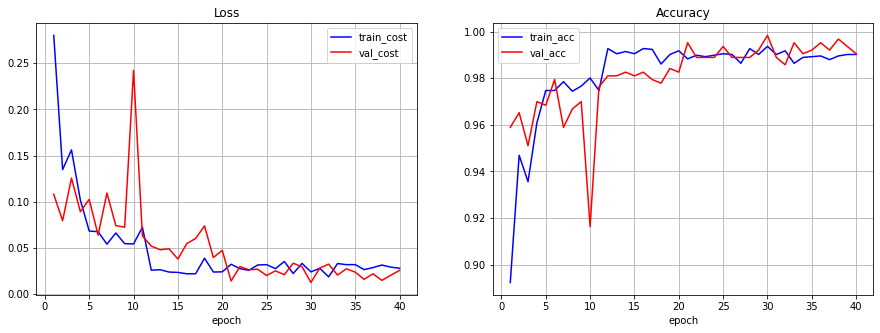

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2)
result_loss.plot(kind='line',x='epoch',y='train_cost',color='blue', ax=axes[0], title="Loss", grid=True, figsize=(15,5))
result_loss.plot(kind='line',x='epoch',y='val_cost', color='red', ax=axes[0], grid=True)

result_acc.plot(kind='line',x='epoch',y='train_acc',color='blue', ax=axes[1], title="Accuracy", grid=True)
result_acc.plot(kind='line',x='epoch',y='val_acc', color='red', ax=axes[1], grid=True)

# Check Data Test Accuracy

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            predictions = scores.argmax(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [ ]:
check_accuracy(testloader, model)

Got 424 / 424 with accuracy 100.00


# Predict and Sanity Check

In [ ]:
weights = torch.load('model_save_final.pth')
model.load_state_dict(weights)
model = model.to(device)

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

[classes[pred] for pred in preds]

['Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected']

In [ ]:
def convert_to_label(x):
    return [label for pred, label in zip(x, train_dataset.classes) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

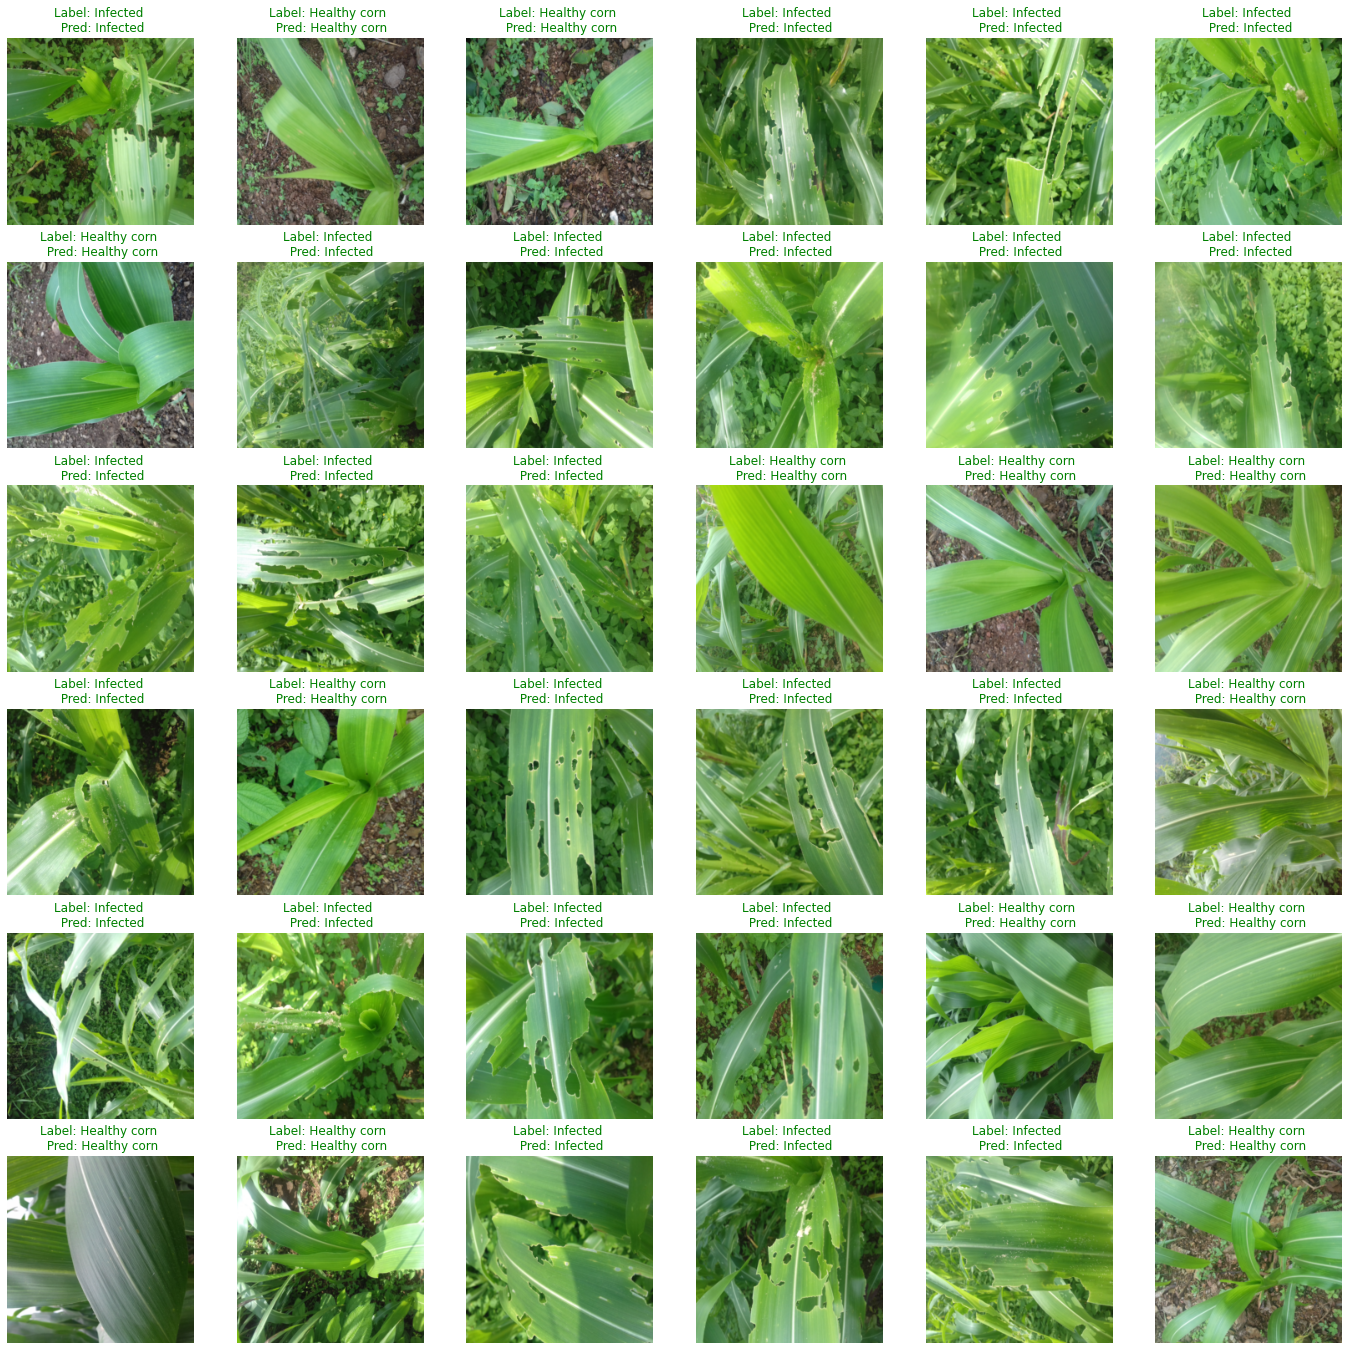

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {'color':'r'} if label != pred else {'color':'g'}
    label, pred = classes[label.item()], classes[pred.item()]
    ax.set_title(f'Label: {label} \n Pred: {pred}', fontdict=font)
    ax.axis('off')